In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage


In [10]:
import pandas as pd

# ==== 0) Parâmetros ====
ARQ_IN    = "Matrix.csv"        # saída do passo anterior (pivot pronto)
OUT_W     = "W_frames.csv"      # pesos por frame (frames × K)
OUT_H     = "H_padroes.csv"     # padrões (K × células)
OUT_TOP   = "frames_tipicos.csv"
SEED      = 42
MAX_ITER  = 2000

# Ler a matriz W gerada pelo NMF (output do passo anterior)
df_W = pd.read_csv("nmf_output_W.csv", index_col=0)

print(f"✅ df_W carregado: {df_W.shape[0]} frames × {df_W.shape[1]} padrões")
df_W.head()


✅ df_W carregado: 1016 frames × 10 padrões


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10
timestamp,,,,,,,,,,
1900-01-01 00:00:00.852,4.411383e-158,0.000000e+00,1.082853e-111,1.694687e-48,1.077243e-02,1.926588e-02,0.000000e+00,0.000000e+00,6.758018e-02,2.188171e-56
1900-01-01 00:00:03.401,1.111919e-02,0.000000e+00,2.205197e-48,2.935007e-35,5.717327e-171,5.616803e-13,1.988925e-108,6.411288e-02,2.410472e-02,3.072434e-27
1900-01-01 00:00:05.246,1.496536e-40,8.434726e-212,2.842379e-318,2.676455e-02,3.871293e-02,1.452070e-100,4.893133e-55,5.524874e-02,0.000000e+00,8.010250e-119
1900-01-01 00:00:07.974,5.565115e-145,0.000000e+00,6.819994e-02,2.091204e-33,0.000000e+00,6.948660e-81,0.000000e+00,5.207727e-119,4.249502e-30,6.524812e-30
1900-01-01 00:00:08.614,6.950248e-02,1.085133e-02,0.000000e+00,1.212129e-118,1.186722e-23,7.200331e-43,1.506655e-14,5.799314e-74,1.683296e-33,7.670745e-34


In [11]:

from sklearn.preprocessing import normalize

X_features = df_W.values
#X_features = normalize(df_W.values, norm="l1")

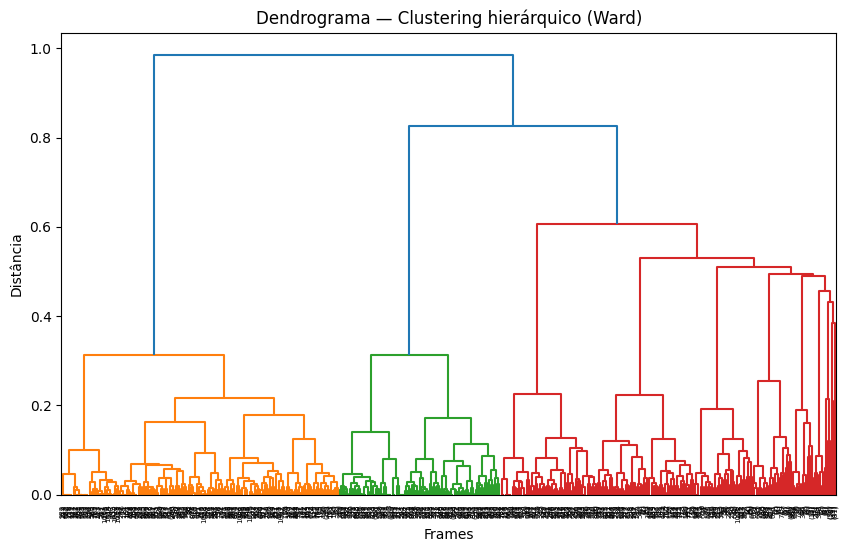

In [ ]:
'''# linkage matrix (Ward minimiza variância)
Z = linkage(X_features, method="ward")



# Dendrograma
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="level", p=10)  # só últimos níveis
plt.title("Dendrograma — Clustering hierárquico (Ward)")
plt.xlabel("Frames")
plt.ylabel("Distância")
plt.grid(False)
plt.show()
'''


📊 Resultados por linkage:
    Linkage  Silhouette  Davies-Bouldin  Calinski-Harabasz     Score
0      ward    0.331772        1.235806         213.733847  0.666667
1  complete    0.269543        1.071392         180.848243  0.790366
2   average    0.292905        1.040499         152.875162  0.799692
3    single   -0.242429        0.976721           1.735072  0.333333

➡️ Melhor linkage: average (Score=0.800)


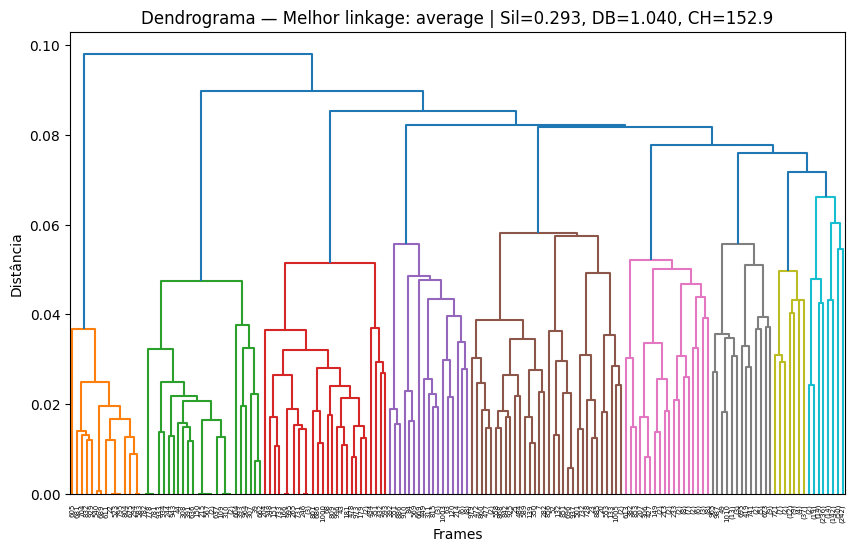

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# ==== Clustering hierárquico em W com comparação de linkages ====
X_features = df_W.values  

linkages = ["ward", "complete", "average", "single"]
resultados = []

max_k = 10  # fixamos K para comparação (podes ajustar se quiseres)

for method in linkages:
    model = AgglomerativeClustering(n_clusters=max_k, linkage=method)
    labels = model.fit_predict(X_features)
    
    sil = silhouette_score(X_features, labels)
    db  = davies_bouldin_score(X_features, labels)
    ch  = calinski_harabasz_score(X_features, labels)
    
    resultados.append((method, sil, db, ch))

# Converter para DataFrame
df_res = pd.DataFrame(resultados, columns=["Linkage", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])

# Normalizar métricas (0–1 para consenso)
df_res["Silhouette_norm"] = (df_res["Silhouette"] - df_res["Silhouette"].min()) / (df_res["Silhouette"].max() - df_res["Silhouette"].min())
df_res["Davies_norm"]     = 1 - (df_res["Davies-Bouldin"] - df_res["Davies-Bouldin"].min()) / (df_res["Davies-Bouldin"].max() - df_res["Davies-Bouldin"].min())
df_res["Calinski_norm"]   = (df_res["Calinski-Harabasz"] - df_res["Calinski-Harabasz"].min()) / (df_res["Calinski-Harabasz"].max() - df_res["Calinski-Harabasz"].min())

df_res["Score"] = df_res[["Silhouette_norm", "Davies_norm", "Calinski_norm"]].mean(axis=1)

# Melhor método
best_method = df_res.loc[df_res["Score"].idxmax()]
best_linkage = best_method["Linkage"]   # <-- 🔑 usado no bloco seguinte

print("📊 Resultados por linkage:")
print(df_res[["Linkage", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz", "Score"]])
print(f"\n➡️ Melhor linkage: {best_linkage} (Score={best_method['Score']:.3f})")

# === Dendrograma do melhor método ===
Z = linkage(X_features, method=best_linkage)

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="level", p=10)
plt.title(f"Dendrograma — Melhor linkage: {best_linkage} | "
          f"Sil={best_method['Silhouette']:.3f}, "
          f"DB={best_method['Davies-Bouldin']:.3f}, "
          f"CH={best_method['Calinski-Harabasz']:.1f}")
plt.xlabel("Frames")
plt.ylabel("Distância")
plt.grid(False)
plt.show()


In [22]:
max_k = 20
Ks, sil_scores, db_scores, ch_scores = [], [], [], []

for k in range(2, max_k+1):
    model = AgglomerativeClustering(n_clusters=k, linkage=best_linkage)  # <-- herda do bloco anterior
    labels = model.fit_predict(X_features)

    Ks.append(k)
    sil_scores.append(silhouette_score(X_features, labels))
    db_scores.append(davies_bouldin_score(X_features, labels))
    ch_scores.append(calinski_harabasz_score(X_features, labels))


In [23]:
# Normalizar métricas (0–1)
sil_norm = (sil_scores - np.min(sil_scores)) / (np.max(sil_scores) - np.min(sil_scores))
db_norm  = 1 - (db_scores - np.min(db_scores)) / (np.max(db_scores) - np.min(db_scores))  # invertido
ch_norm  = (ch_scores - np.min(ch_scores)) / (np.max(ch_scores) - np.min(ch_scores))

# Score combinado
final_score = sil_norm + db_norm + ch_norm
K_best = Ks[np.argmax(final_score)]

print(f"➡️ Número de clusters escolhido (hierárquico, linkage={best_linkage}): {K_best}")


➡️ Número de clusters escolhido (hierárquico, linkage=average): 11


In [24]:
# ==== Clustering final com K_best e linkage ótimo ====
final_model = AgglomerativeClustering(n_clusters=K_best, linkage=best_linkage)
final_labels = final_model.fit_predict(X_features)

# Guardar resultados no DataFrame
df_clusters = df_W.copy()
df_clusters["cluster"] = final_labels
df_clusters["timestamp"] = df_W.index

print("✅ Clusters atribuídos")
print(df_clusters.head())

# Distribuição de frames por cluster
print("\nDistribuição por cluster:")
print(df_clusters["cluster"].value_counts())


✅ Clusters atribuídos
                              padrao_1       padrao_2       padrao_3  \
timestamp                                                              
1900-01-01 00:00:00.852  4.411383e-158   0.000000e+00  1.082853e-111   
1900-01-01 00:00:03.401   1.111919e-02   0.000000e+00   2.205197e-48   
1900-01-01 00:00:05.246   1.496536e-40  8.434726e-212  2.842379e-318   
1900-01-01 00:00:07.974  5.565115e-145   0.000000e+00   6.819994e-02   
1900-01-01 00:00:08.614   6.950248e-02   1.085133e-02   0.000000e+00   

                              padrao_4       padrao_5       padrao_6  \
timestamp                                                              
1900-01-01 00:00:00.852   1.694687e-48   1.077243e-02   1.926588e-02   
1900-01-01 00:00:03.401   2.935007e-35  5.717327e-171   5.616803e-13   
1900-01-01 00:00:05.246   2.676455e-02   3.871293e-02  1.452070e-100   
1900-01-01 00:00:07.974   2.091204e-33   0.000000e+00   6.948660e-81   
1900-01-01 00:00:08.614  1.212129e-118   

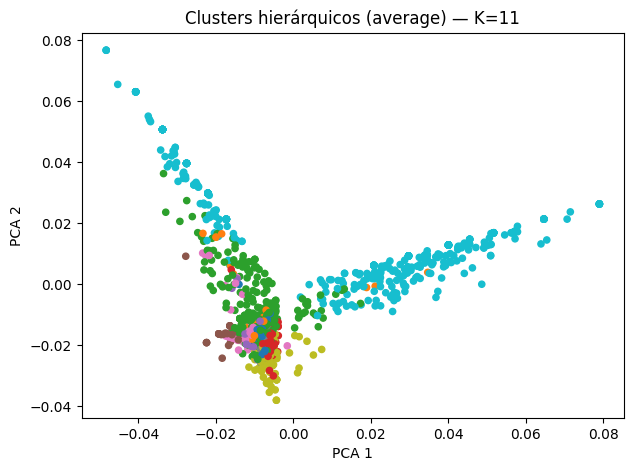

In [ ]:
'''from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=SEED)
X_pca = pca.fit_transform(X_features)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=final_labels, cmap="tab10", s=20)
plt.title(f"Clusters hierárquicos ({best_linkage}) — K={K_best}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(False)
plt.show()
'''

In [30]:
import plotly.express as px
from sklearn.decomposition import PCA

# ==== PCA para 3 componentes ====
pca = PCA(n_components=3, random_state=SEED)
X_pca = pca.fit_transform(X_features)

# DataFrame para visualização
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2", "PCA3"])
df_pca["cluster"] = final_labels

# ==== Gráfico 3D interativo ====
fig = px.scatter_3d(
    df_pca,
    x="PCA1", y="PCA2", z="PCA3",
    color="cluster",
    title=f"Clusters hierárquicos ({best_linkage}) — K={K_best}",
    opacity=0.7,
    symbol="cluster"
)
fig.update_traces(marker=dict(size=4))
fig.show()


/home/rfmra/.venv/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [27]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ==== Métricas de clusterização (validação) ====
X_features = df_W.values  
labels = df_clusters["cluster"].values  

silhouette = silhouette_score(X_features, labels)        # varia de -1 a 1; >0.3 já indica clusters razoáveis
davies     = davies_bouldin_score(X_features, labels)   # quanto menor, melhor; valores próximos de 1 são bons
calinski   = calinski_harabasz_score(X_features, labels) # quanto maior, melhor; valores altos indicam boa separação

print(f"📊 Métricas de clusterização (Hierárquico — {best_linkage})")
print(f"Silhouette Score:        {silhouette:.4f}")
print(f"Davies-Bouldin Index:    {davies:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")


📊 Métricas de clusterização (Hierárquico — average)
Silhouette Score:        0.3219
Davies-Bouldin Index:    1.0593
Calinski-Harabasz Index: 204.9998


In [18]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

# Calcular centróides manualmente
centroids = []
for c in range(K_best):
    cluster_points = X_features[final_labels == c]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

# Encontrar o ponto mais próximo do centróide em cada cluster
closest, _ = pairwise_distances_argmin_min(centroids, X_features)

# Marcar os medoids no df_clusters
df_clusters["is_medoid"] = False
df_clusters.iloc[closest, df_clusters.columns.get_loc("is_medoid")] = True

# Mostrar resultados
print("📌 Frames representativos (medoids) por cluster:")
print(df_clusters[df_clusters["is_medoid"]][["timestamp", "cluster"]])


📌 Frames representativos (medoids) por cluster:
                                       timestamp  cluster
timestamp                                                
1900-01-01 00:07:33.283  1900-01-01 00:07:33.283        3
1900-01-01 00:14:45.819  1900-01-01 00:14:45.819       10
1900-01-01 00:20:17.594  1900-01-01 00:20:17.594        8
1900-01-01 00:21:56.068  1900-01-01 00:21:56.068        0
1900-01-01 00:25:33.558  1900-01-01 00:25:33.558        5
1900-01-01 00:28:45.358  1900-01-01 00:28:45.358        7
1900-01-01 00:36:33.010  1900-01-01 00:36:33.010        4
1900-01-01 00:39:41.319  1900-01-01 00:39:41.319        9
1900-01-01 00:39:57.383  1900-01-01 00:39:57.383        2
1900-01-01 00:40:37.730  1900-01-01 00:40:37.730        1
1900-01-01 00:46:09.035  1900-01-01 00:46:09.035        6


In [19]:
# Guardar clusters e medoids
df_clusters.to_csv("clusters_hierarchical.csv", index=False)

# Apenas os timestamps dos medoids
df_clusters[df_clusters["is_medoid"]][["timestamp", "cluster"]].to_csv("medoid_timestamps_hierarchical.csv", index=False)
